# Time Series Analysis: Tutorial 3

## Import packages

In [120]:
import numpy as np
import math
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rc('text', usetex=True)
import pandas as pd
import statsmodels.api as sm

## Data

In [121]:
#Load the oil-, Siemens-, production- and unemployment-datasets.
oil=pd.read_stata('/home/nudse/Dokumente/Uni/Arbeit TU Berlin/TSA WS 2021/Tutorials/Tutorial 3/oil.dta')
siemens=pd.read_stata('/home/nudse/Dokumente/Uni/Arbeit TU Berlin/TSA WS 2021/Tutorials/Tutorial 3/Siemens.dta')
prod=pd.read_stata('/home/nudse/Dokumente/Uni/Arbeit TU Berlin/TSA WS 2021/Tutorials/Tutorial 3/prod.dta')
unemp=pd.read_stata('/home/nudse/Dokumente/Uni/Arbeit TU Berlin/TSA WS 2021/Tutorials/Tutorial 3/unemp.dta')
time = pd.date_range(start="2000", periods=105, freq="M")
data = pd.DataFrame(time, columns=['date'])
oil=data.assign(oil=oil.values)
unemp

,unemp,time
0,5.010488,2006-01-01
1,5.047683,2006-02-01
2,4.977421,2006-03-01
3,4.790465,2006-04-01
4,4.538312,2006-05-01
5,4.398619,2006-06-01
6,4.386315,2006-07-01
7,4.371864,2006-08-01
8,4.237655,2006-09-01
9,4.084369,2006-10-01


## Smoothing

We want to look at three examplary smoothing methods: Exponential smoothing, Holt-Winter's two parameter exponential smoothing and the Hodrick-Prescott filter.

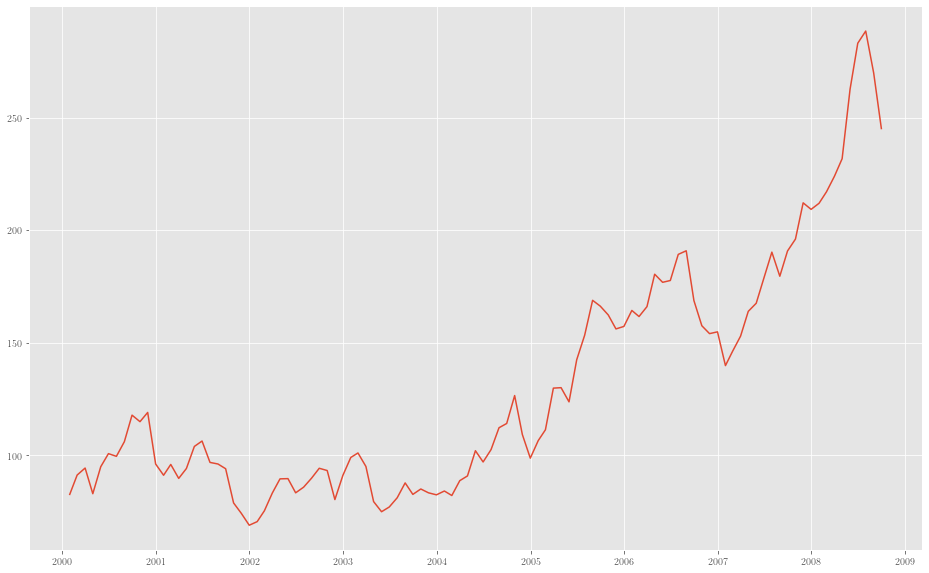

In [5]:
#Plot the crude oil import price index.
fig, ax=plt.subplots(figsize=(16,10))
plt.plot(oil['date'],oil['oil'])

## Exponentially weighted moving average

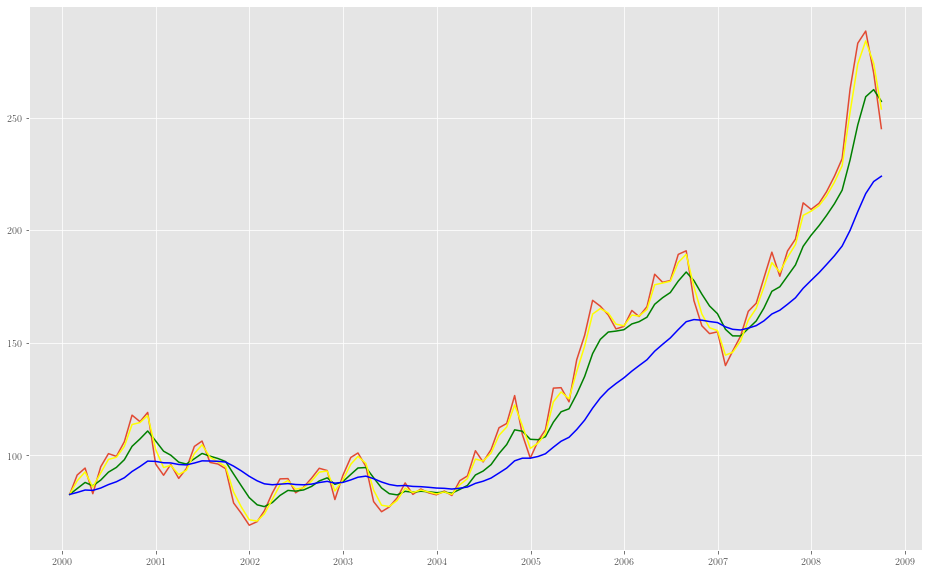

In [6]:
#Generate smoothed data via EWMA
#function receives data and smoothing parameter alpha.
def EWMA(data,alpha):
    data_smoothed=[data[0]]
    for i in range(1,len(data)):
        smooth=alpha*data[i]+(1-alpha)*data_smoothed[i-1]
        data_smoothed.append(smooth)
    return data_smoothed
    
oil_smoothed_03=EWMA(oil['oil'].values,0.3)
oil_smoothed_07=EWMA(oil['oil'].values,0.7)
oil_smoothed_01=EWMA(oil['oil'].values,0.1)


#Plot the crude oil import price index.
fig, ax=plt.subplots(figsize=(16,10))
plt.plot(oil['date'],oil['oil'])
plt.plot(oil['date'],oil_smoothed_03,c='green')
plt.plot(oil['date'],oil_smoothed_07,c='yellow')
plt.plot(oil['date'],oil_smoothed_01,c='blue')

Is the model appropriate to predict the oil price? Justify with the help of the graph, in particular the years after 2004. In order to answer this question you should consider the properties of exponential smoothing where we smooth the observed data $\{x_t\}_{t=1}^n$ via

\begin{align}
y_0&=x_0\\
y_t&=\alpha x_t+(1-\alpha)y_{t-1}\text{ for } t\geqslant1
\end{align}

and some $\alpha\in(0,1)$ in order to obtain smoothed data $\{y_t\}_{t=1}^n$.

## Combining linear trend with smoothing

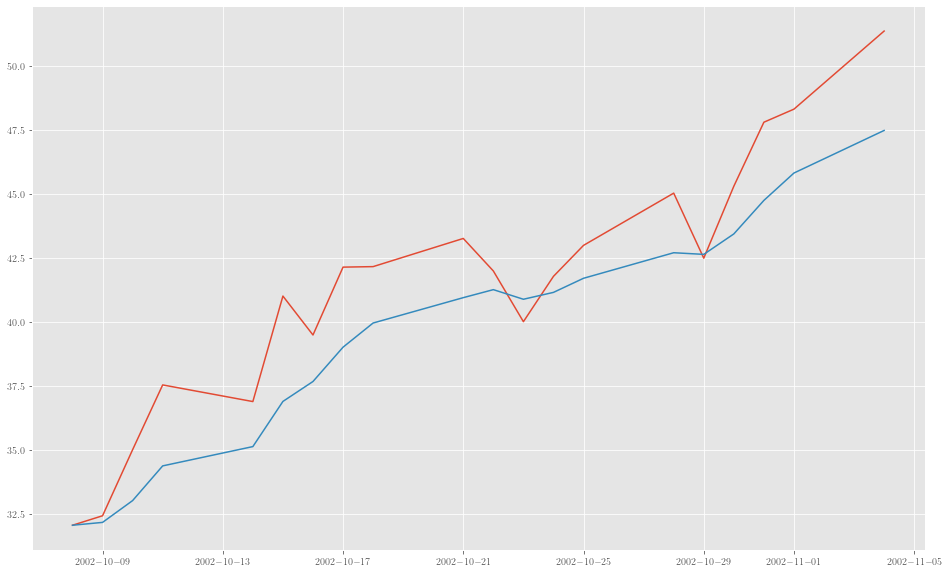

In [7]:
#The preceeding example shows that exponential smoothing over-/underpredicts in the presence of a deterministic
#trend. In order to mitigate this problem one can first detrend and then use EWMA. We want to do this for the
#Siemens-data. Let us plot it first together with smoothed data for alpha=0.3.

#Note that we ignore the fact that the data is daily data without the weekends. This will cause the regression line
#note to appear linear. You could solve this by giving saturdays and sundays the value of its preceeding friday.

siemens_smoothed=EWMA(siemens['SIE'].values,0.3)
fig, ax=plt.subplots(figsize=(16,10))
plt.plot(siemens['time'],siemens['SIE'])
plt.plot(siemens['time'],siemens_smoothed)

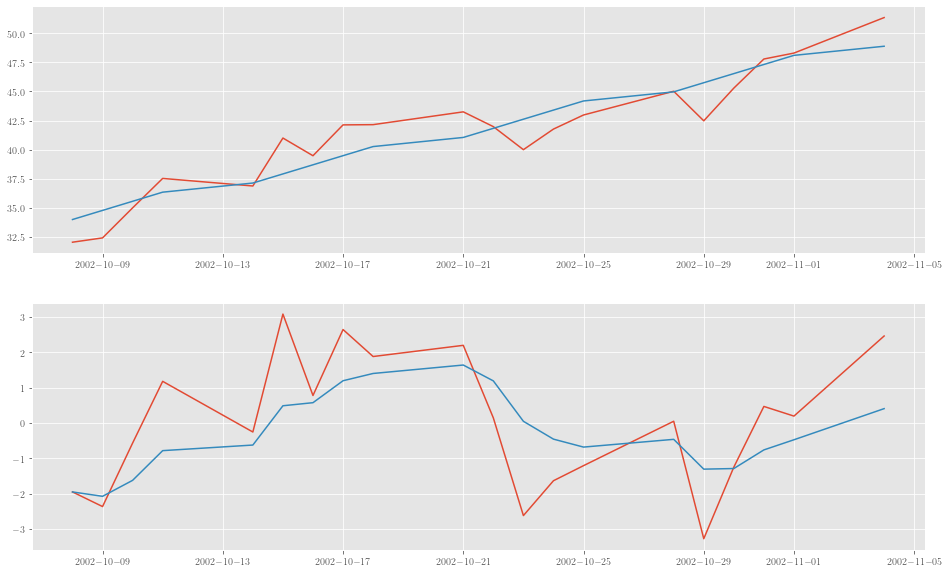

In [8]:
#Now first estimate the deterministic linear trend, detrend the series and then smooth the detrended series
#using EWMA with alpha=0.3. Plot everything.
y=siemens['SIE']

#We use days as the time variable.
t_periods=[i for i in range(1,21)]
X=sm.add_constant(t_periods)
model = sm.OLS(y,X)
result = model.fit()

#Get trend and detrend.
trend = result.predict(X)
siemens_detrended = y-trend

#Smooth.
siemens_detrended_smoothed=EWMA(siemens_detrended.values,0.3)

#Plot.
fig, ax=plt.subplots(2,1,figsize=(16,10))
ax[0].plot(siemens['time'],siemens['SIE'])
ax[0].plot(siemens['time'],trend)
ax[1].plot(siemens['time'],siemens_detrended)
ax[1].plot(siemens['time'],siemens_detrended_smoothed)

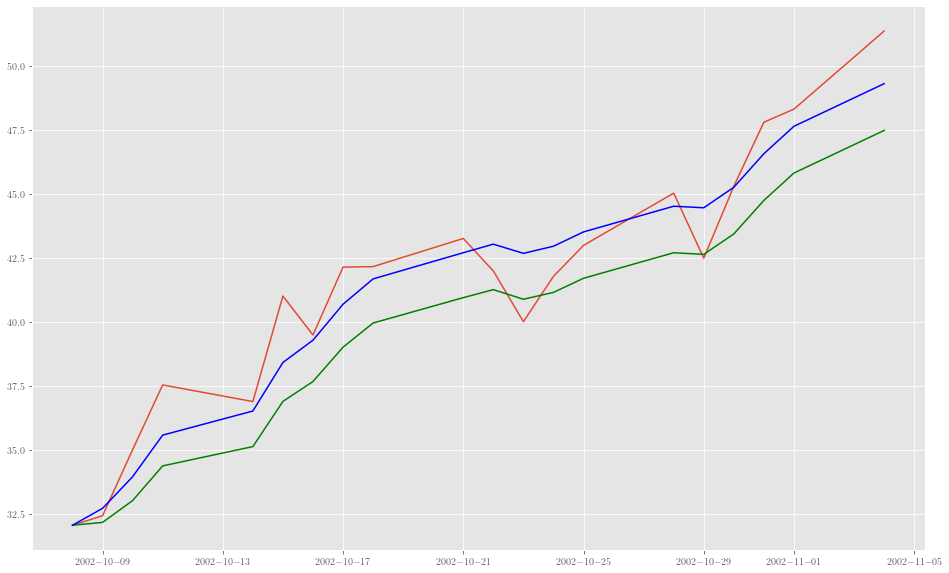

In [9]:
#Add the trend and the smoothed detrended series back together and plot the result against the original series.
siemens_smoothed_2=trend+siemens_detrended_smoothed
fig, ax=plt.subplots(figsize=(16,10))
plt.plot(siemens['time'],siemens['SIE'])
plt.plot(siemens['time'],siemens_smoothed,c='green')
plt.plot(siemens['time'],siemens_smoothed_2,c='blue')

##  Holt-Winter's two parameter exponential smoothing

In this case we smooth the observed data $\{x_t\}_{t=1}^n$ via

\begin{align}
y_0&=x_0,\\
r_0&=0,\\
y_t&=\alpha x_t+(1-\alpha)(y_{t-1}+r_{t-1})\text{ for } t\geqslant1,\\
r_t&=\gamma(y_t-y_{t-1})+(1-\gamma)r_{t-1}\text{ for } t\geqslant1
\end{align}

and some $\alpha,\gamma\in(0,1)$ in order to obtain smoothed data $\{y_t\}_{t=1}^n$. Here $\{r_t\}_{t=1}^n$ is a smooth series which represents the trend. Therefore this procedure is ment to handle the existence of a trend over time.

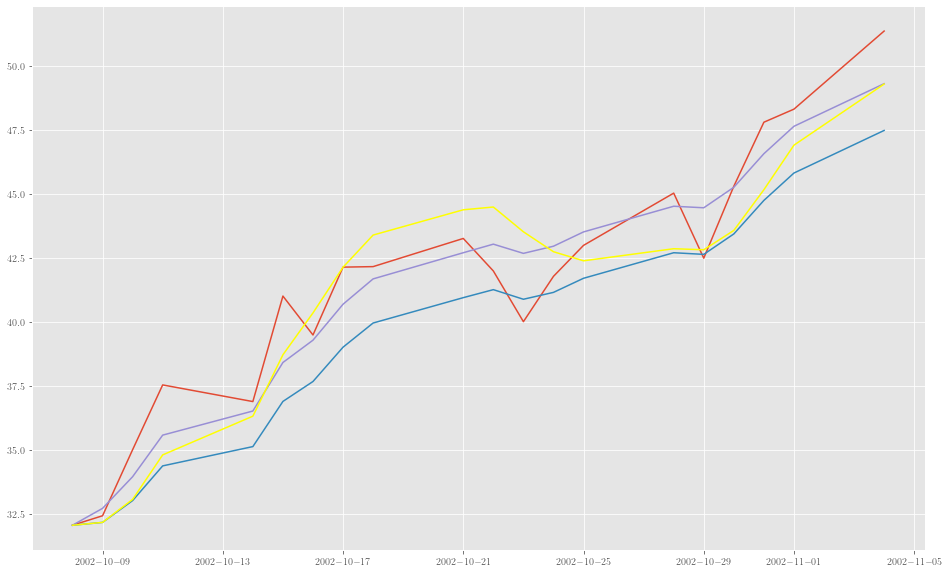

In [10]:
#Rerun the whole procedure on the Siemens-data with the Holt-Winter's two parameter exponential smoothing. We choose
#alpha=0.3 and gamma=0.6.
def doubleEWMA(data,alpha,gamma):
    data_smoothed=[data[0]]
    trend_smoothed=[0]
    for i in range(1,len(data)):
        smooth=alpha*data[i]+(1-alpha)*(data_smoothed[i-1]+trend_smoothed[i-1])
        trend=gamma*(smooth-data_smoothed[i-1])+(1-gamma)*trend_smoothed[i-1]
        data_smoothed.append(smooth)
        trend_smoothed.append(trend)
    return data_smoothed

#Compute the smoothed series.
siemens_smoothed_03_06=doubleEWMA(siemens['SIE'],0.3,0.6)

#Plot the original and the smoothed series.
fig, ax=plt.subplots(figsize=(16,10))
plt.plot(siemens['time'],siemens['SIE'])
plt.plot(siemens['time'],siemens_smoothed)
plt.plot(siemens['time'],siemens_smoothed_2)
plt.plot(siemens['time'],siemens_smoothed_03_06,c='yellow')

$\bf{EXERCISE:}$ Rerun the estimation for different values of $\alpha$ and $\gamma$.

## Hodrick-Prescott filter

The Hodrick-Prescott filter solves the optimization problem

\begin{align}
\min_\tau\sum_{t=1}^T(y_t-\tau_t)^2+\lambda\sum_{t=2}^{T-1}[(\tau_{t+1}-\tau_t)-(\tau_t-\tau_{t-1})]^2
\end{align}

where $\tau=\begin{bmatrix}\tau_1&\ldots&\tau_T\end{bmatrix}$ is the smoothed series and $\lambda$ a hyperparameter to be chosen beforehand. In the lecture slides - or simply by computing the FOC - you can see that solving this for optimal $\tau$ amounts to solving a system of linear equations.

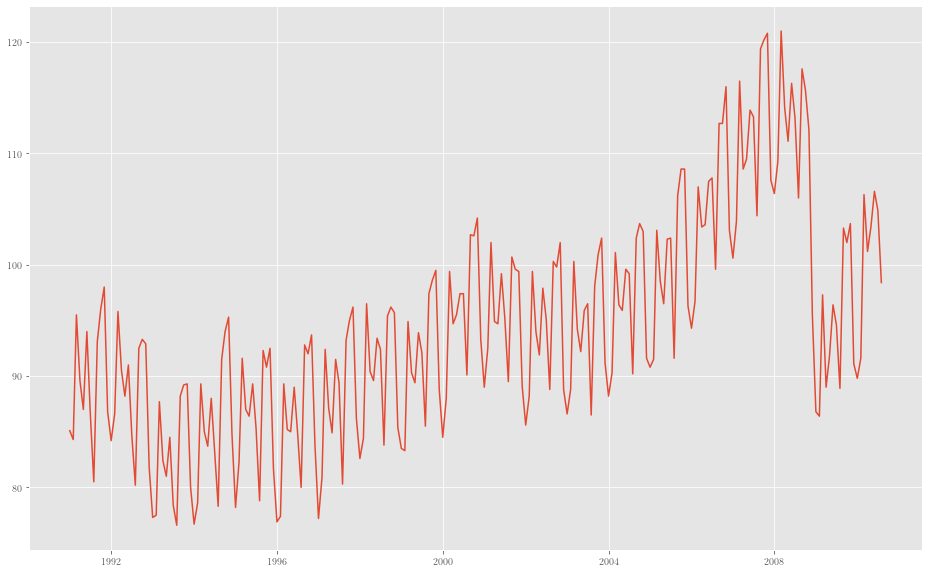

In [12]:
#Plot the prod-data. It is monthly data.
fig, ax=plt.subplots(figsize=(16,10))
plt.plot(prod['time'],prod['prod'])

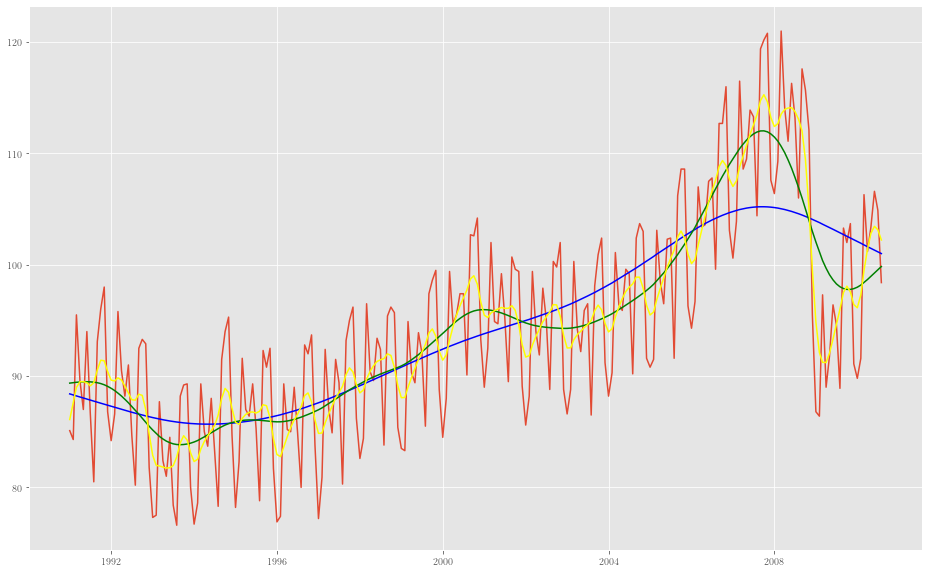

In [13]:
#Use the statsmodels command hpfilter to estimate the smoothed series for the prod-data.
#Note that the command returns two arrays. One for the trend and one for the cycle. The cycle is merely
#the original series minus the trend.
#Also the documentation from statsmodels speaks about different optimal values for lambda:
#129600(monthly), 1600(quarterly), 6.25(annual)
cycle_129600, trend_129600=sm.tsa.filters.hpfilter(prod['prod'],lamb=129600)
cycle_1600, trend_1600=sm.tsa.filters.hpfilter(prod['prod'],lamb=1600)
cycle_625, trend_625=sm.tsa.filters.hpfilter(prod['prod'],lamb=6.25)


#Plot the original series together with the smoothed series.
fig, ax=plt.subplots(figsize=(16,10))
plt.plot(prod['time'],prod['prod'])
plt.plot(prod['time'],trend_129600,c='blue')
plt.plot(prod['time'],trend_1600,c='green')
plt.plot(prod['time'],trend_625,c='yellow')

## Seasonal Adjustment 

Our goal is spot all seasonality in the data and control for it, i.e. eliminate the seasonal effects. In order to do so we assume a multiplicative model

\begin{align}
y_t=L_t\cdot C_t\cdot S_t\cdot I_t
\end{align}

and first estimate $G_t=L_t\cdot C_t$ with some smoothing method or other detrending procedure. Then we obtain $S_t\cdot I_t=y_t/(L_t\cdot C_t)$. Further we elimate $I_t$ by averaging over seasonal periods and finally we can estimate a seasonally adjusted series via $y_t^{\text{SA}}=y_t/S_t$.

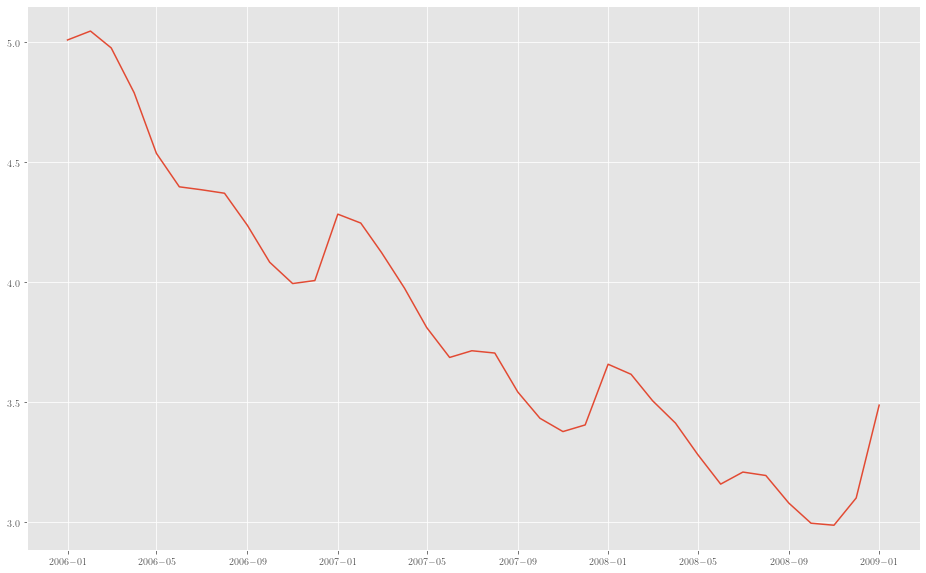

In [122]:
#Plot the unemployment-data against time. What seasonality can you detect?
fig, ax=plt.subplots(figsize=(16,10))
plt.plot(unemp['time'],unemp['unemp'])

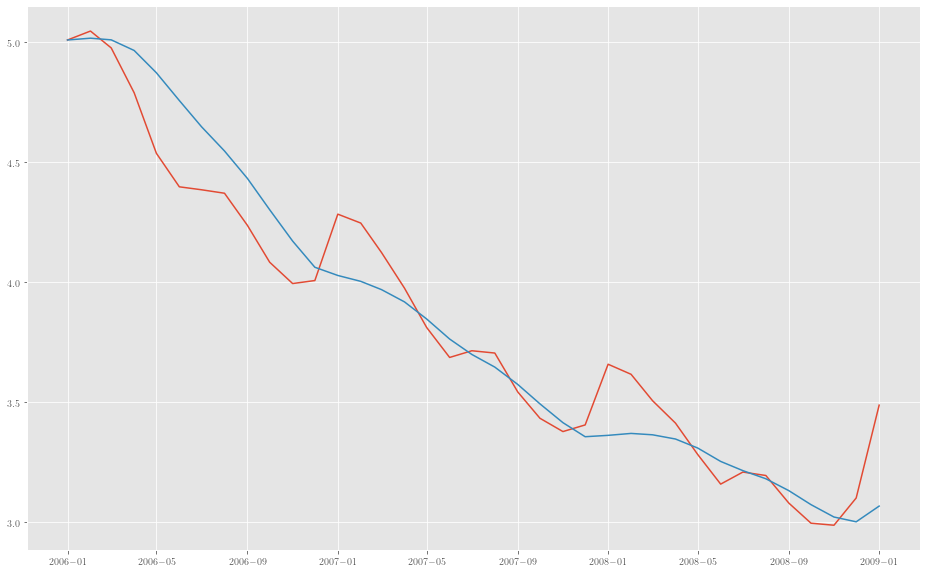

In [123]:
#Compute the trend via doubleEWMA. Plot the trend against the original data.
unemp_smoothed=doubleEWMA(unemp['unemp'].values,0.2,0.2)
fig, ax=plt.subplots(figsize=(16,10))
plt.plot(unemp['time'],unemp['unemp'])
plt.plot(unemp['time'],unemp_smoothed)

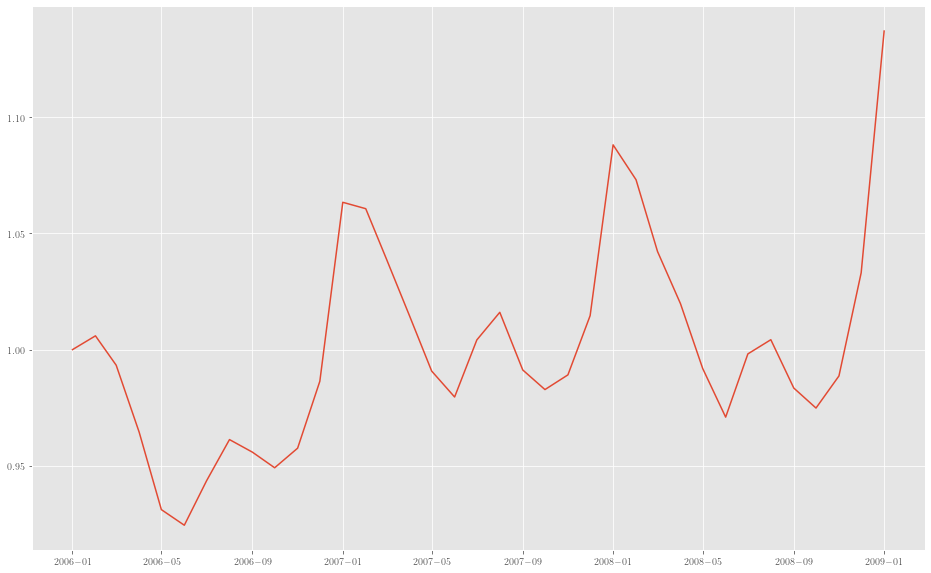

In [124]:
#Compute S_t*I_t and plot it.
rest=unemp['unemp'].values/unemp_smoothed
fig, ax=plt.subplots(figsize=(16,10))
plt.plot(unemp['time'],rest)

In [125]:
#The solution above does not look convincing. Let us try with moving averages and write a function in order
#to do this.
def ma(data,periods):
    if periods%2==0:
        k=int(periods/2)
        weights=[1/(2*periods)]+[(1/periods) for i in range(periods-1)]+[1/(2*periods)]
        smoothed=np.convolve(data,weights)
        result=smoothed[k:-k]
        #adapt at the boundaries
        for i in range(k):
            weights=[(1/(k+1+i)) for j in range(k+i)]+[1/(2*(k+1+i))]
            result[i]=np.average(data[:k+1+i],weights=weights)
            weights.reverse()
            result[-(i+1)]=np.average(data[-(k+1+i):],weights=weights)
        return(result)
    else:
        k=round(periods/2)
        weights=[(1/periods) for i in range(periods)]
        smoothed=np.convolve(data,weights)
        result=smoothed[k:-k]
        #adapt at the boundaries
        for i in range(k):
            weights=[(1/(k+1+i)) for j in range(k+i)]
            result[i]=np.average(data[:k+i],weights=weights)
            weights.reverse()
            result[-(i+1)]=np.average(data[-(k+i):],weights=weights)
        return(result)

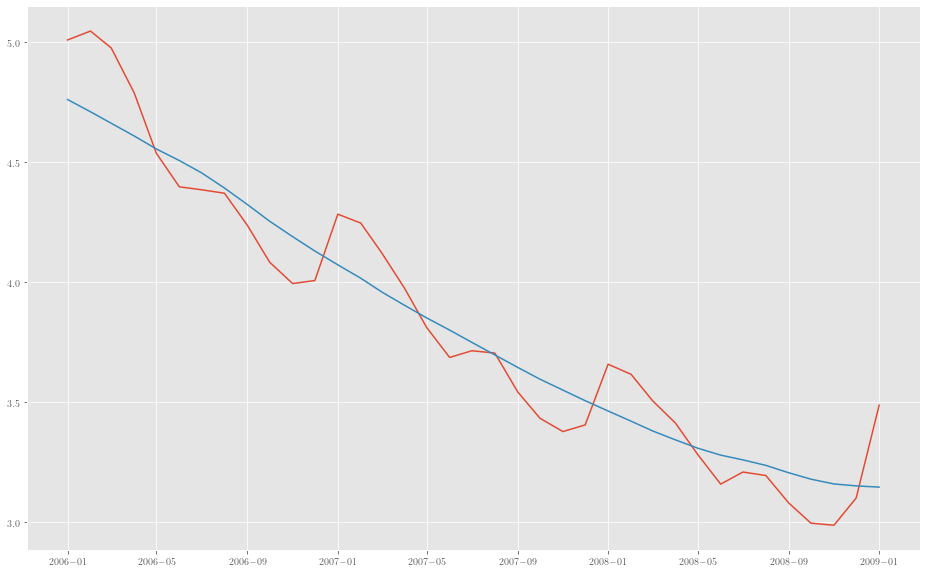

In [127]:
unemp_smoothed_ma=ma(unemp['unemp'].values,12)
fig, ax=plt.subplots(figsize=(16,10))
plt.plot(unemp['time'],unemp['unemp'])
plt.plot(unemp['time'],unemp_smoothed_ma)

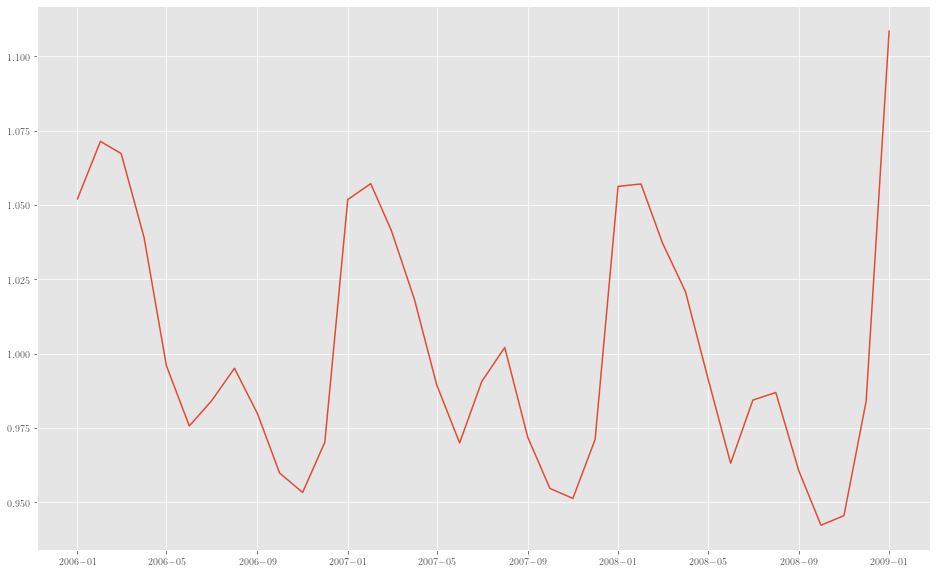

In [128]:
rest=unemp['unemp'].values/unemp_smoothed_ma
fig, ax=plt.subplots(figsize=(16,10))
plt.plot(unemp['time'],rest)

In [129]:
#Compute monthwise averages of S_t*I_t. This eliminates I_t and gives a seasonal index. Then you deseasonalize
#the original series by deviding each value with the corresponding index.
seasonal_index=[0 for i in range(12)]
weights=[1/4]+[1/3 for i in range(11)]
for i in range(len(rest)):
    seasonal_index[i%12]+=weights[i%12]*rest[i]
#It is important to actually generate a copy of the unemp-data. Otherwise changes to unemp_adj will
#always also change unemp['unemp'].values, since both point to the same list.
unemp_adj=unemp['unemp'].values.copy()
for i in range(len(unemp['unemp'].values)):
    unemp_adj[i]=unemp_adj[i]/seasonal_index[i%12]
unemp['unemp_seasonally_adj']=unemp_adj

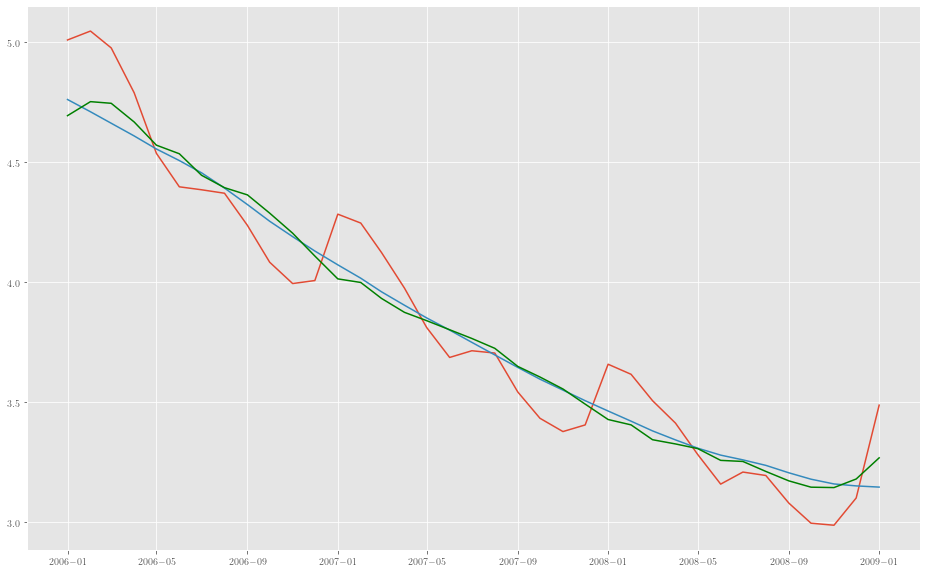

In [134]:
#Plot seasonally adjusted series against original series together with the smoothed series.
fig, ax=plt.subplots(figsize=(16,10))
plt.plot(unemp['time'],unemp['unemp'])
plt.plot(unemp['time'],unemp_smoothed_ma)
plt.plot(unemp['time'],unemp['unemp_seasonally_adj'],c='g')